In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import re
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("review_data_chungnam.csv")
df.head(20)

,score,review,y
0,5.0,분위기 좋고 커피 맛있어요,1
1,3.0,NaN,0
2,4.0,아인슈페너맛남 배산임수 친절하진않음,1
3,3.0,아메리카노 6천원. 자리 많고 분위기는 좋지만 커피 마시겠다고 들르면 아쉬울수도,0
4,5.0,NaN,1
5,3.0,NaN,0
6,3.0,분위기는 좋은데 가격이 굳이,0
7,4.0,분위기 좋은 카페였어요. 예쁜 사진도 많이 찍을 수 있어요. 사람이 많아 자리가 없...,1
8,5.0,NaN,1
9,3.0,커피 맛 분위기 다 ㄱㅊ은데 선곡이 너무 구림 진심. . . 갑자기 감성카페에서 시...,0


In [3]:
def text_cleaning(text):
    # 정규표현식으로 한글만 추출
        hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
        result = hangul.sub('', text)
        return result

In [4]:
df = pd.read_csv("review_data_chungnam.csv")
row = []
for i in df['review']:
    row.append(text_cleaning(str(i)))

df['ko_text'] = row
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출
df = df[df['ko_text'].str.len() > 0]
df.tail(5)

,score,y,ko_text
2104,2.0,0,가격이 저렴한 것도 아니면서 메인패티가 큰 것도 아니어서 애매하네요
2106,5.0,1,연취 그만 좋아해그거 어떻게 하는건데 연취는 맛있었다
2108,3.0,0,양꼬치는 느끼했고 꿔바로우는 물컹한 부분이 많아서 별로였는데 다른 메뉴가 궁금하긴 함
2109,5.0,1,김찌가 원픽이었는데 먹다보니 전메뉴 다 먹어봤어요 원래 순두부찌개가 이런맛이었나 싶...
2110,5.0,1,먹고가면 내가 순찌 먹은거 온세상 사람들이 알 정도의 냄새지만개맛있기 때문에 먹음


In [5]:
########################### 여기서부터 자연어처리를 위한 과정 ###########################

In [6]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'].values[0])
print(result)

['분위기/Noun', '좋고/Adjective', '커피/Noun', '맛있어요/Adjective']


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [8]:
X.shape

(1611, 7448)

In [9]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'분위기/Noun': 3330, '좋고/Adjective': 5884, '커피/Noun': 6595, '맛있어요/Adjective': 2476, '아인/Noun': 4328, '..


In [11]:
print(df['ko_text'].values[0])
print(X[0])

분위기 좋고 커피 맛있어요
  (0, 3330)	1
  (0, 5884)	1
  (0, 6595)	1
  (0, 2476)	1


In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

print(X.shape)
print(X[0])

(1611, 7448)
  (0, 6595)	0.4954853204890856
  (0, 5884)	0.5739975065687312
  (0, 3330)	0.49984546941638297
  (0, 2476)	0.4185399220344739


In [13]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
print(x_train.shape)
print(x_test.shape)

(1288, 7448)
(323, 7448)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test,y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

accuracy: 0.77
Precision: 0.768
Recall: 0.987
F1: 0.864


In [15]:
import pickle
with open('맛집리뷰분석_충남대.model', 'wb') as fw:
  pickle.dump(lr, fw)

In [16]:
from sklearn.metrics import confusion_matrix

confmat=confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 14  71]
 [  3 235]]


In [17]:
# y가 0과 1을 각각 얼마나 가지고 있는지를 출력
df['y'].value_counts()

y
1    1140
0     471
Name: count, dtype: int64

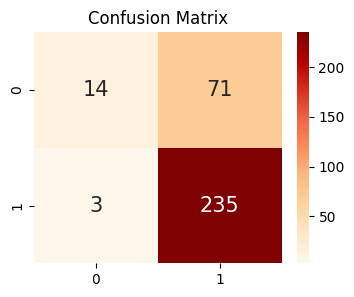

In [18]:
# 오차행렬
import seaborn as sns
confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

AUC: 0.874


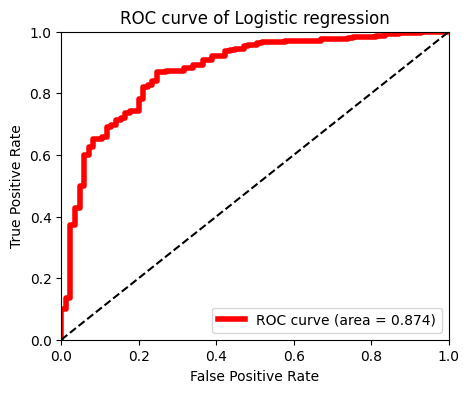

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC: %.3f" % roc_auc)

plt.rcParams['figure.figsize']=[5,4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, color='red', linewidth=4.0)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

[(2.4636854804149553, 2476), (1.6112750850158728, 2501), (1.6007126980580417, 6442), (1.3276070714202577, 5900), (1.2988294235123514, 2443)]
[(-1.6651870245778766, 1400), (-1.7096185496743581, 5191), (-1.7784728101686451, 3153), (-2.0247136101930643, 695), (-2.427672027376915, 5182)]


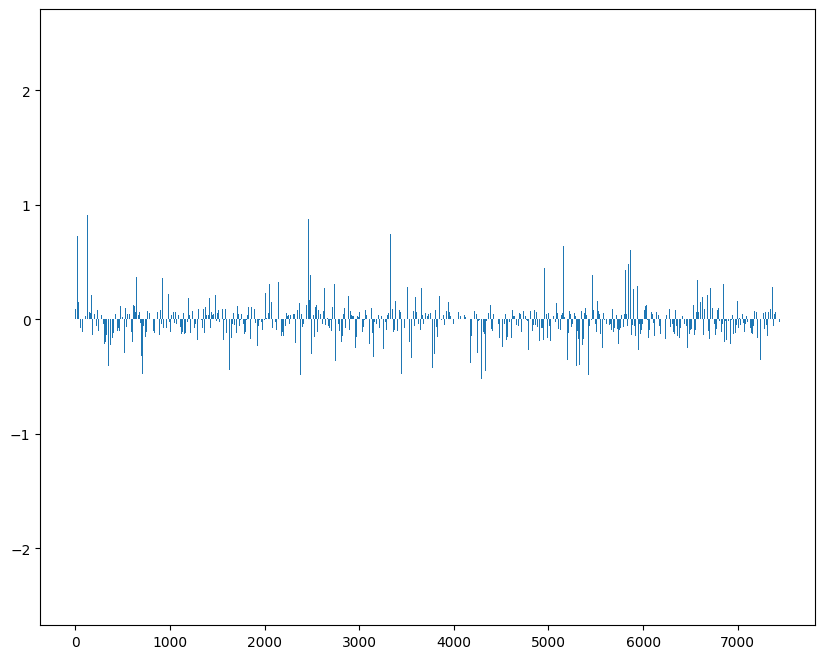

In [20]:
plt.rcParams['figure.figsize'] = [10,8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
print(sorted(((value, index)for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index)for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

In [21]:
# 회귀모델의 계수를 기준으로 내림차순 정렬
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [22]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력
invert_index_vectorizer = {v:k for k, v in index_vectorizer.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{3330: '분위기/Noun', 5884: '좋고/Adjective', 6595: '커피/Noun', 2476: '맛있어요/Adjective', 4328: '아인/Noun', 3..


In [23]:
# 계수가 높은 순으로 피처에 형태소 맵핑한 결과 출력, 이때 계수가 높은 피쳐는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있다.
for coef in coef_pos_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요/Adjective 2.4636854804149553
맛있음/Adjective 1.6112750850158728
최고/Noun 1.6007126980580417
좋아요/Adjective 1.3276070714202577
맛있고/Adjective 1.2988294235123514
존맛/Noun 1.258778660268039
도/Josa 1.257452211732394
맛있었어요/Adjective 1.159727187706434
정말/Noun 1.0852903507729221
대전/Noun 1.044962170244285


In [24]:
# 하위 10개 부정 형태소 출력
for coef in coef_pos_index[-10:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최악/Noun -1.3262184132466566
이/Josa -1.3549663298165484
불친절/Noun -1.3576741706104065
안/VerbPrefix -1.4267545209910402
평범/Noun -1.5051835517994843
는/Josa -1.6651870245778766
을/Josa -1.7096185496743581
별로/Noun -1.7784728101686451
그냥/Noun -2.0247136101930643
은/Josa -2.427672027376915


In [25]:
#긍정
pos_key = []
pos_value = []
for coef in coef_pos_index[:50]:   #20단어 뽑기
    pos_key.append(invert_index_vectorizer[coef[1]])
    pos_value.append(coef[0])
pos_wc = dict(zip(pos_key, pos_value))  #딕셔너리로 변환
pos_wc

{'맛있어요/Adjective': 2.4636854804149553,
 '맛있음/Adjective': 1.6112750850158728,
 '최고/Noun': 1.6007126980580417,
 '좋아요/Adjective': 1.3276070714202577,
 '맛있고/Adjective': 1.2988294235123514,
 '존맛/Noun': 1.258778660268039,
 '도/Josa': 1.257452211732394,
 '맛있었어요/Adjective': 1.159727187706434,
 '정말/Noun': 1.0852903507729221,
 '대전/Noun': 1.044962170244285,
 '맛있네요/Adjective': 1.0320235960992508,
 '또/Noun': 0.971740052339937,
 '디저트/Noun': 0.9527985945141336,
 '가성/Noun': 0.9145625047067226,
 '국밥/Noun': 0.9106585913274704,
 '맛있습니다/Adjective': 0.8936656185695415,
 '맛있다/Adjective': 0.8782934187954612,
 '좋고/Adjective': 0.8708429731902666,
 '여기/Noun': 0.7842052907902906,
 '좋았어요/Adjective': 0.7773638725581886,
 '맛집/Noun': 0.764095852399732,
 '분위기/Noun': 0.7429634669369061,
 '꼭/Noun': 0.741423217489893,
 '대형/Noun': 0.7407945047883654,
 '웨이팅/Noun': 0.7344058830781709,
 'ㅎㅎ/KoreanParticle': 0.7310787907386165,
 '소/Modifier': 0.6878583205702672,
 '국물/Noun': 0.6771028543803596,
 '맛있는/Adjective': 0.669154014750

In [26]:
#부정
neg_key = []
neg_value = []
for coef in coef_pos_index[-50:]:   #20단어 뽑기
    neg_key.append(invert_index_vectorizer[coef[1]])
    neg_value.append(coef[0])
for v in range(len(neg_value)):     #절댓값 처리(음수를 양수로)
    neg_value[v] = abs(neg_value[v])
neg_wc = dict(zip(neg_key, neg_value))  #딕셔너리로 변환
neg_wc

{'많이/Modifier': 0.6304016820271238,
 '맛있는데/Adjective': 0.6312223603164041,
 '비해/Verb': 0.6320815694549525,
 '요/Josa': 0.6366299149871364,
 '곳/Noun': 0.6379294165434162,
 '그냥/Modifier': 0.6495261374151541,
 '다른/Modifier': 0.6506226234776422,
 '비싸/Adjective': 0.655644066461374,
 '별/Modifier': 0.6666837338988919,
 '하고/Josa': 0.6701707775259732,
 'ㅠ/KoreanParticle': 0.6750557932318955,
 '으로/Josa': 0.6892433274221814,
 '그/Determiner': 0.6908807876272755,
 '무난/Noun': 0.7016699504319238,
 '불친절함/Adjective': 0.7046327884058867,
 '하네요/Verb': 0.7105952022634048,
 '함/Noun': 0.7237328455682088,
 '불친절해요/Adjective': 0.728552811808508,
 '짜요/Verb': 0.7327475825183822,
 '짜고/Verb': 0.7390967588569368,
 '적당히/Adjective': 0.7539547557103754,
 '아님/Adjective': 0.7619168353207811,
 '다신/Verb': 0.77107551360495,
 '비싸요/Adjective': 0.7879807680707586,
 '왜/Noun': 0.8047791424892102,
 '너무/Adverb': 0.821526024784928,
 '마세요/Verb': 0.8426807043588065,
 '보통/Noun': 0.8443169491581753,
 '인지/Josa': 0.8529200830634003,
 '맛없

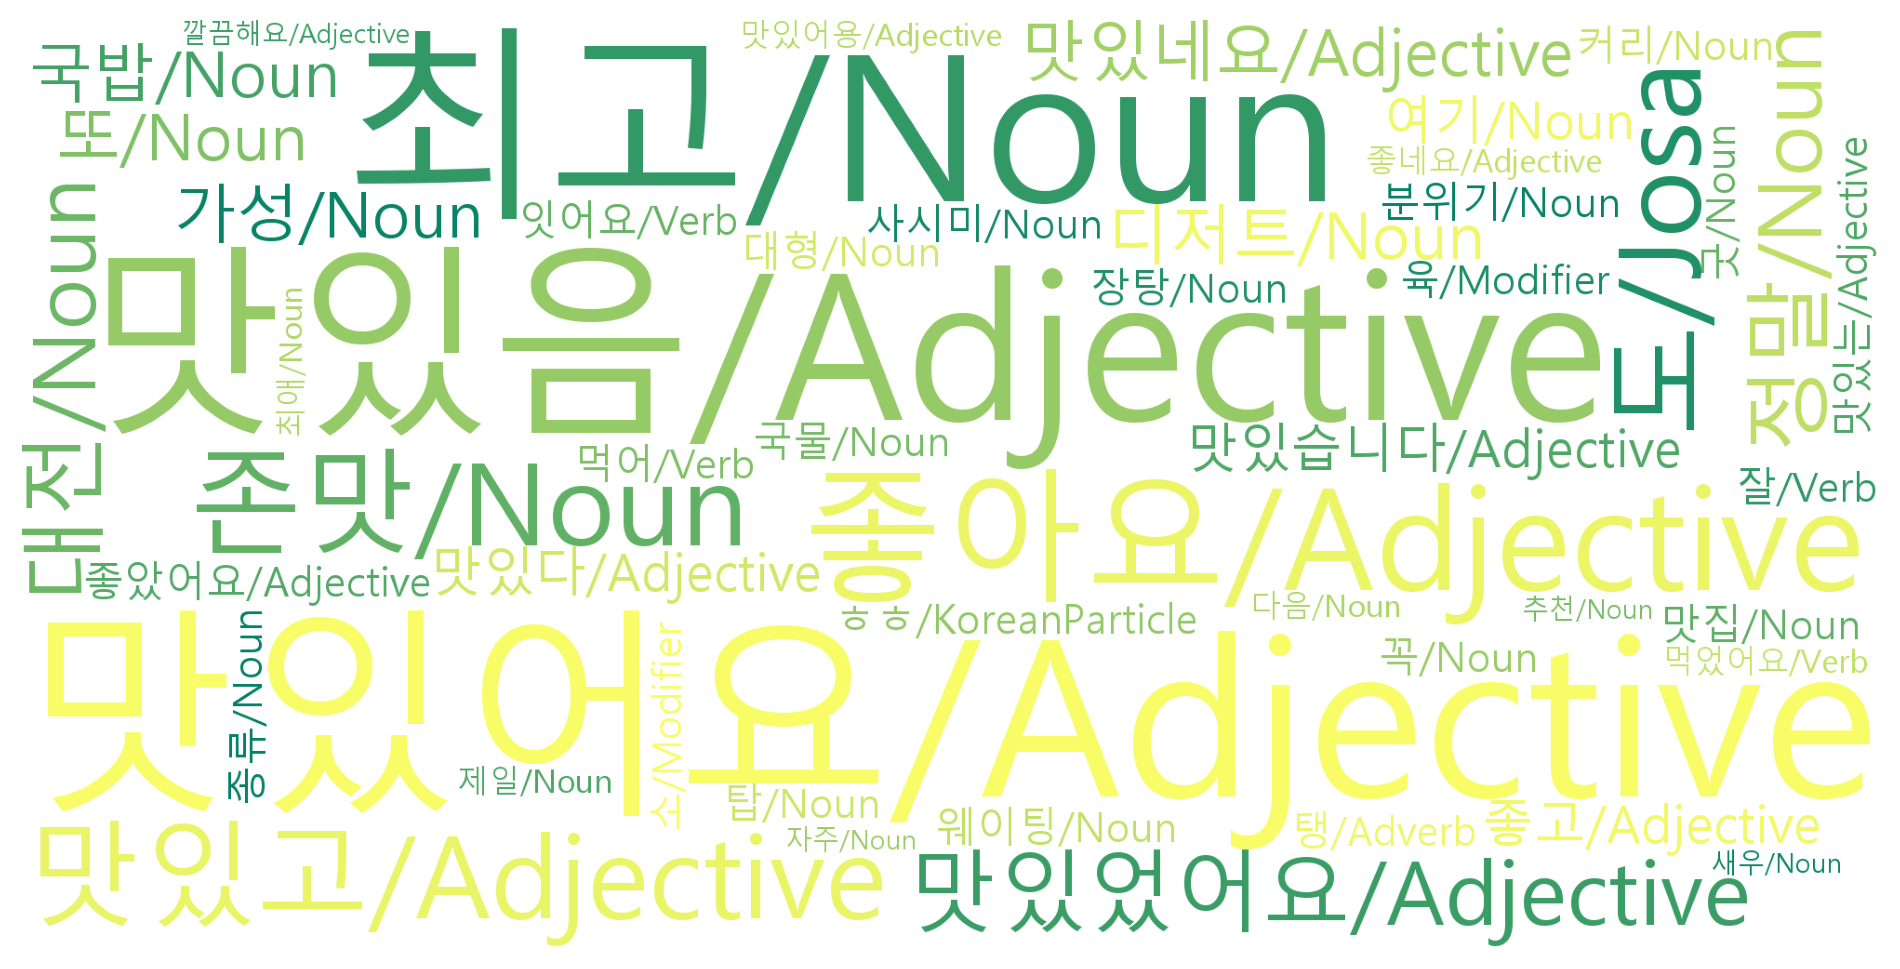

In [27]:
from wordcloud import WordCloud
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
wordcloud = WordCloud(font_path= "c:/Windows/fonts/malgun.ttf", 
                      relative_scaling = 0.2,
                      max_font_size = 600, 
                      background_color='white',
                      colormap = 'summer',
                      width=2000, height=1000).generate_from_frequencies(pos_wc)

plt.figure(figsize = (12,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

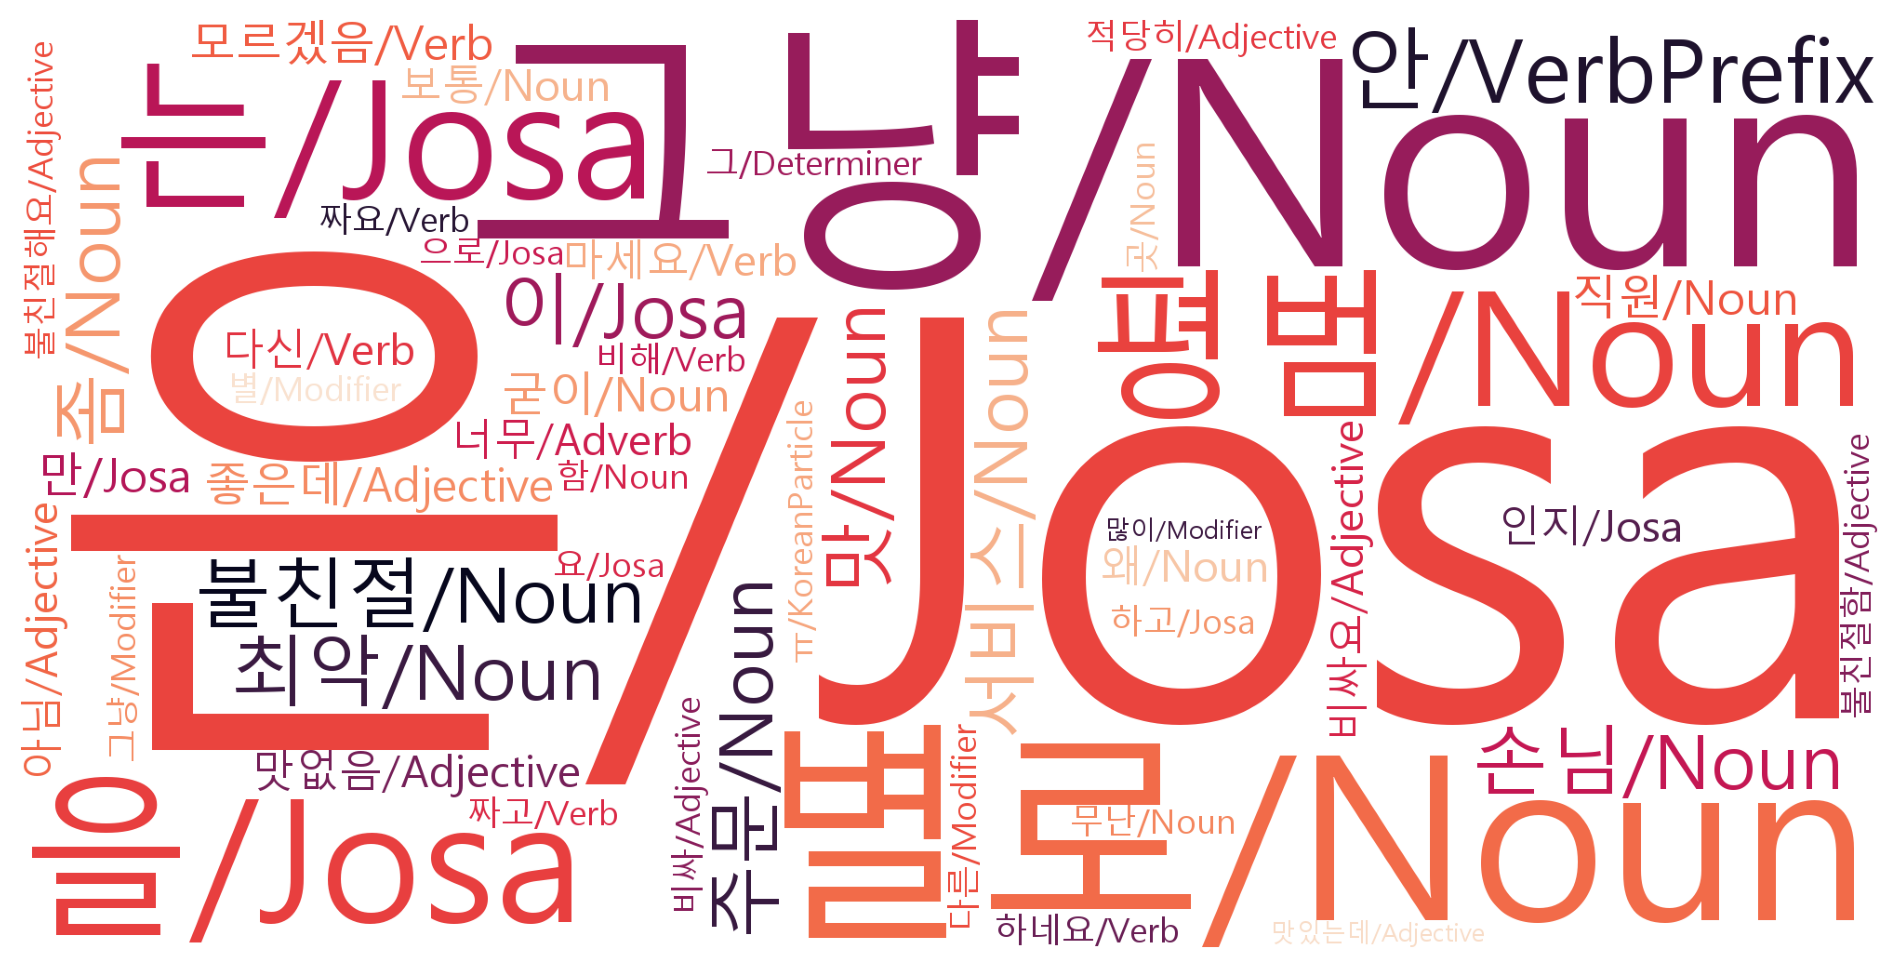

In [29]:
wordcloud = WordCloud(font_path = 'c:/Windows/fonts/malgun.ttf', 
                      relative_scaling = 0.2,
                      max_font_size = 600,
                      background_color='white',
                      colormap = "rocket_r", 
                      width=2000, height=1000).generate_from_frequencies(neg_wc) 

plt.figure(figsize = (12,8))                
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

In [30]:
# 보기좋은 워드클라우드 가시화를 위한 코드

In [31]:
df['y'].value_counts()

y
1    1140
0     471
Name: count, dtype: int64

In [32]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}'.format(word[0]) for word in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'].values[0])
print(result)

['분위기', '좋고', '커피', '맛있어요']


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [34]:
X.shape

(1611, 7288)

In [35]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'분위기': 3256, '좋고': 5748, '커피': 6448, '맛있어요': 2421, '아인': 4238, '슈페': 3806, '너': 1204, '맛남': 2355, '..


In [36]:
print(df['ko_text'].values[0])
print(X[0])

분위기 좋고 커피 맛있어요
  (0, 3256)	1
  (0, 5748)	1
  (0, 6448)	1
  (0, 2421)	1


In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

print(X.shape)
print(X[0])

(1611, 7288)
  (0, 6448)	0.4954853204890856
  (0, 5748)	0.5739975065687312
  (0, 3256)	0.49984546941638297
  (0, 2421)	0.4185399220344739


In [38]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(1127, 7288)
(484, 7288)


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test,y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

accuracy: 0.77
Precision: 0.767
Recall: 0.974
F1: 0.859


In [40]:
with open('맛집리뷰분석_충남대_재학습.model', 'wb') as fw:
  pickle.dump(lr, fw)

In [41]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [42]:
invert_index_vectorizer = {v:k for k, v in index_vectorizer.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{3256: '분위기', 5748: '좋고', 6448: '커피', 2421: '맛있어요', 4238: '아인', 3806: '슈페', 1204: '너', 2355: '맛남', 3..


In [43]:
for coef in coef_pos_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요 2.142916502481824
최고 1.556468097748125
도 1.4555951442768247
맛있음 1.41608401796487
좋아요 1.4066235019975655
맛있고 1.371067682997852
맛있었어요 1.2743661553004766
대전 1.2491704840192648
정말 1.0956121133962644
맛있습니다 1.0572379918548844


In [44]:
for coef in coef_pos_index[-10:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

손님 -1.2073671175335945
맛 -1.2798538214269608
맛없음 -1.2821740308098204
이 -1.3186590452742242
을 -1.3638616096668166
안 -1.4186927908449587
별로 -1.815621946399064
그냥 -1.862828514337432
는 -1.9120272966393579
은 -2.011828010812818


In [45]:
#긍정
pos_key = []
pos_value = []
for coef in coef_pos_index[:50]:   #50단어 뽑기
    pos_key.append(invert_index_vectorizer[coef[1]])
    pos_value.append(coef[0])
pos_wc = dict(zip(pos_key, pos_value))  #딕셔너리로 변환
pos_wc

{'맛있어요': 2.142916502481824,
 '최고': 1.556468097748125,
 '도': 1.4555951442768247,
 '맛있음': 1.41608401796487,
 '좋아요': 1.4066235019975655,
 '맛있고': 1.371067682997852,
 '맛있었어요': 1.2743661553004766,
 '대전': 1.2491704840192648,
 '정말': 1.0956121133962644,
 '맛있습니다': 1.0572379918548844,
 '맛있다': 1.035749565708753,
 '국밥': 0.9268538879666702,
 '또': 0.9070502017791792,
 '존맛': 0.8756798064413291,
 '가성': 0.8601143280794362,
 '잘': 0.7747054424052201,
 '분위기': 0.7596717102898635,
 '칼국수': 0.756282230772344,
 '맛있는': 0.7556026923848135,
 '꼭': 0.7554355585669544,
 '국물': 0.7478000398974731,
 '좋고': 0.7368934745823479,
 'ㅎㅎ': 0.7148358691807662,
 '이랑': 0.6941376996256392,
 '맛있네요': 0.6926994388941717,
 '딱': 0.6734428467446559,
 '좋았어요': 0.6709117761434387,
 '잇어요': 0.6621765766342804,
 '맛있게': 0.6594885217444812,
 '웨이팅': 0.6563236934070605,
 '맛있어용': 0.6562123474381711,
 '탱': 0.6513697529617095,
 '디저트': 0.6443643145051342,
 '카페': 0.6371087005152134,
 '장탕': 0.6349035433365466,
 '깔끔하고': 0.6309219529101417,
 '여기': 0.62348

In [46]:
#부정
neg_key = []
neg_value = []
for coef in coef_pos_index[-50:]:   #50단어 뽑기
    neg_key.append(invert_index_vectorizer[coef[1]])
    neg_value.append(coef[0])
for v in range(len(neg_value)):     #절댓값 처리(음수를 양수로)
    neg_value[v] = abs(neg_value[v])
neg_wc = dict(zip(neg_key, neg_value))  #딕셔너리로 변환
neg_wc

{'별': 0.6012795541944292,
 '인': 0.6016108836959984,
 '장사': 0.601906798290126,
 '이렇게': 0.6041773367042337,
 '맛없어요': 0.6054115375431205,
 '직원': 0.609888151497104,
 '돈가스': 0.6145875008635518,
 '비쌈': 0.6228515281180014,
 '대비': 0.6285941259434235,
 '밍밍': 0.6298549006657812,
 '비싸고': 0.6546796980391815,
 '한': 0.6807191957706251,
 '하네요': 0.6861755367679181,
 '함': 0.6979858079702749,
 '청소': 0.7020026023504086,
 '알바생': 0.7072584575680493,
 '인지': 0.7190222626149732,
 '그': 0.7197074242037107,
 '라멘': 0.7215383576632327,
 '으로': 0.7232930436329668,
 '말': 0.7320405097361266,
 '노맛': 0.7589507585566354,
 '불친절해요': 0.7880314772891512,
 '짜고': 0.7975045679309991,
 '무난': 0.8069896227509936,
 '면': 0.825144620575566,
 '보통': 0.8329143166723192,
 '왜': 0.8592298726798742,
 '비싸요': 0.8703681190566277,
 '모르겠음': 0.8750457675219462,
 '굳이': 0.9717924042722805,
 '마세요': 0.975333698376075,
 '만': 0.985464360114523,
 '짜요': 0.9956589246554292,
 '평범': 1.001056887839534,
 '최악': 1.054426783574979,
 '서비스': 1.0873436873503255,
 '

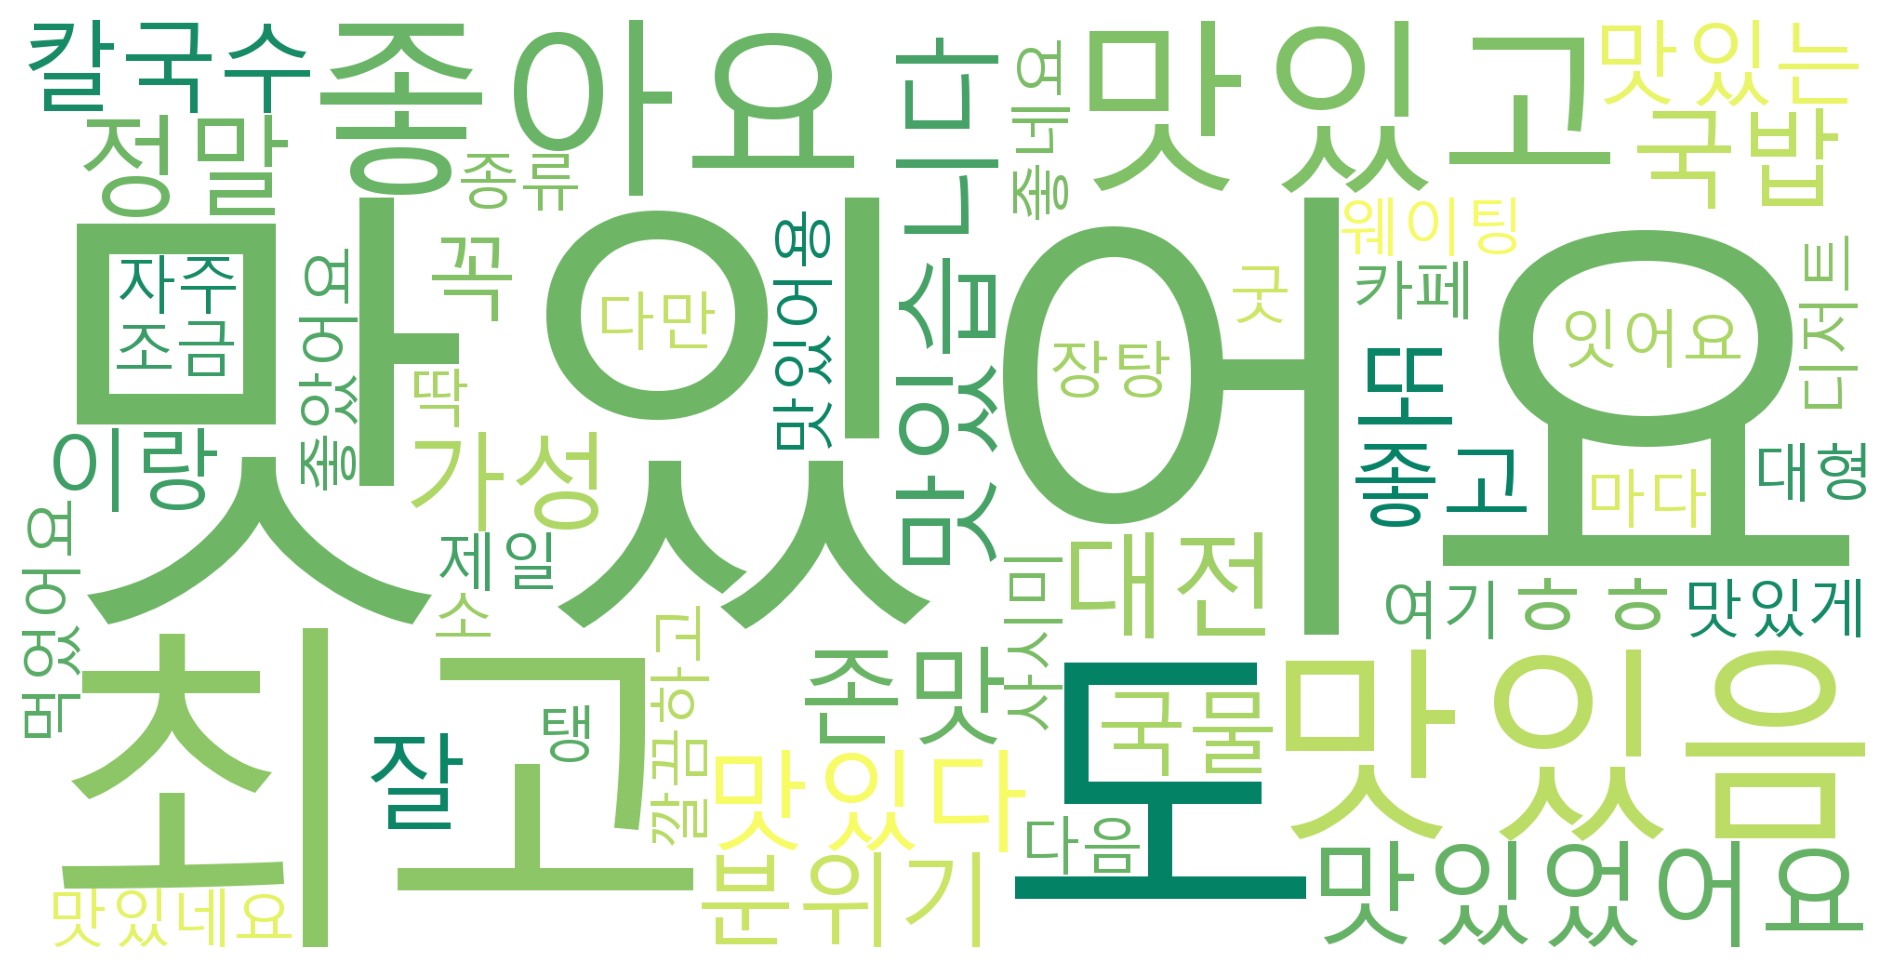

In [47]:
from wordcloud import WordCloud
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
wordcloud = WordCloud(font_path= "c:/Windows/fonts/malgun.ttf", 
                      relative_scaling = 0.2,
                      max_font_size = 600, 
                      background_color='white',
                      colormap = 'summer',
                      width=2000, height=1000).generate_from_frequencies(pos_wc)

plt.figure(figsize = (12,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

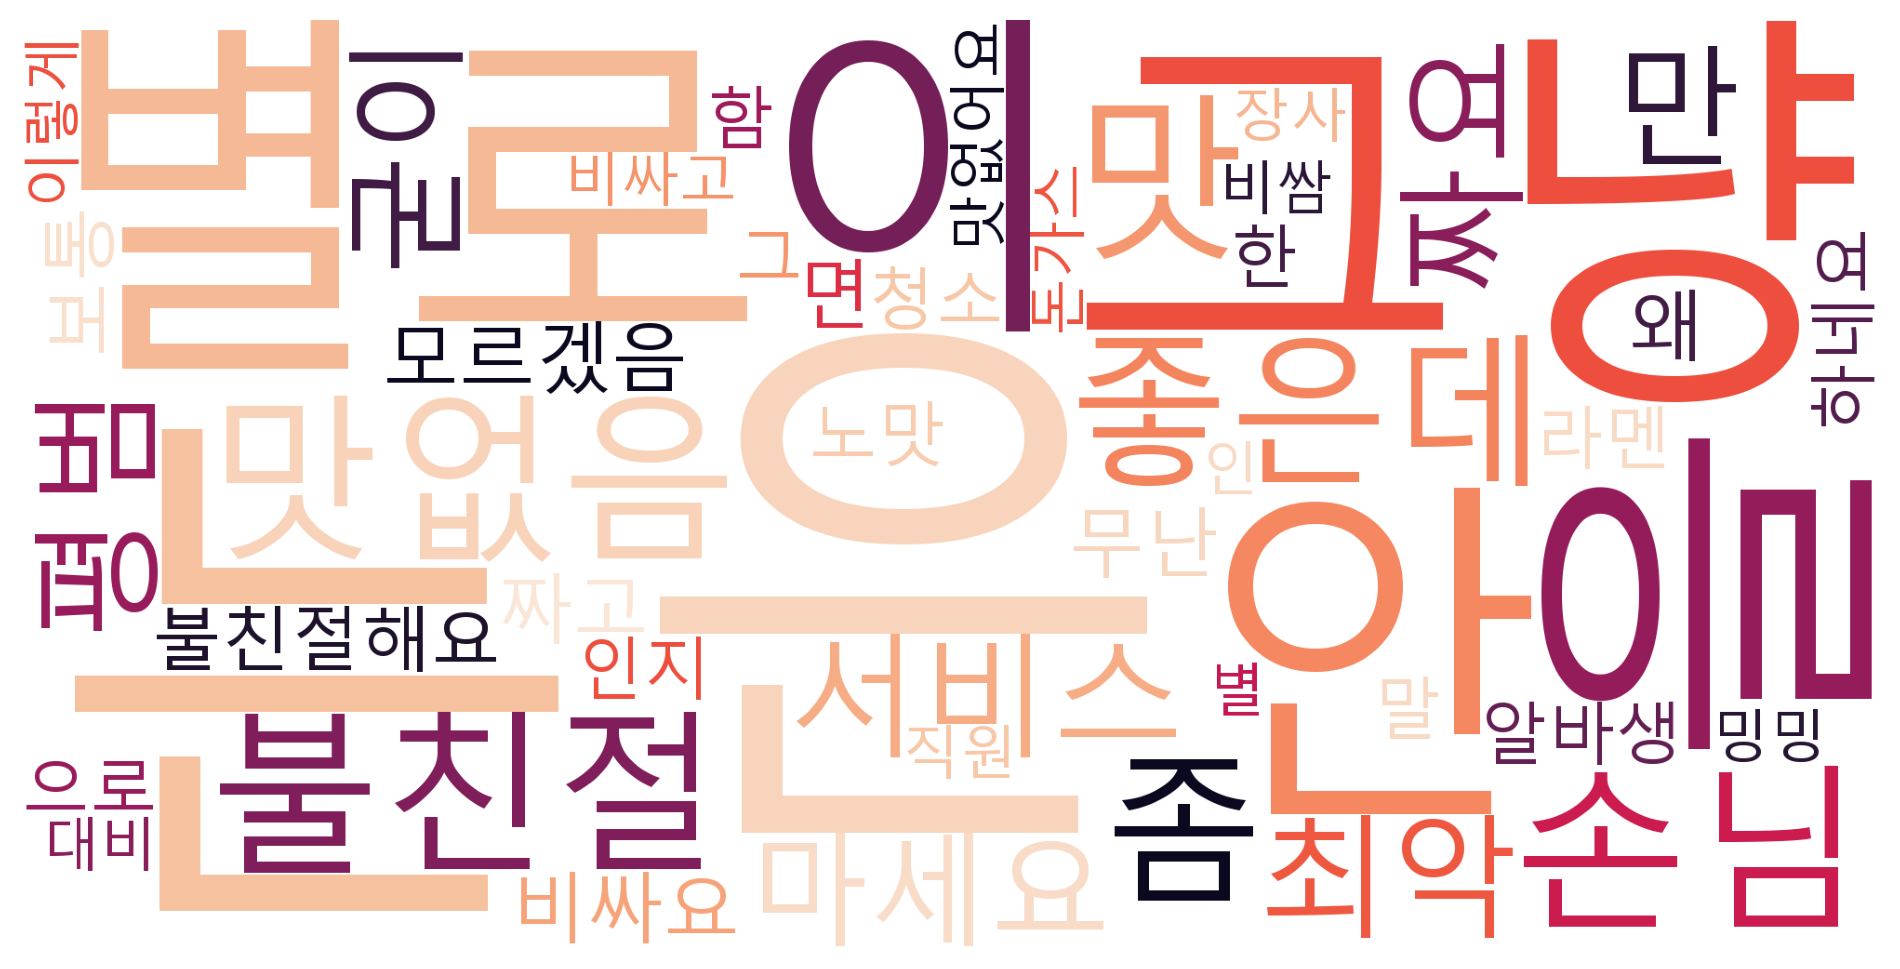

In [48]:
wordcloud = WordCloud(font_path = 'c:/Windows/fonts/malgun.ttf', 
                      relative_scaling = 0.2,
                      max_font_size = 600,
                      background_color='white',
                      colormap = "rocket_r", 
                      width=2000, height=1000).generate_from_frequencies(neg_wc) 

plt.figure(figsize = (12,8))                
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

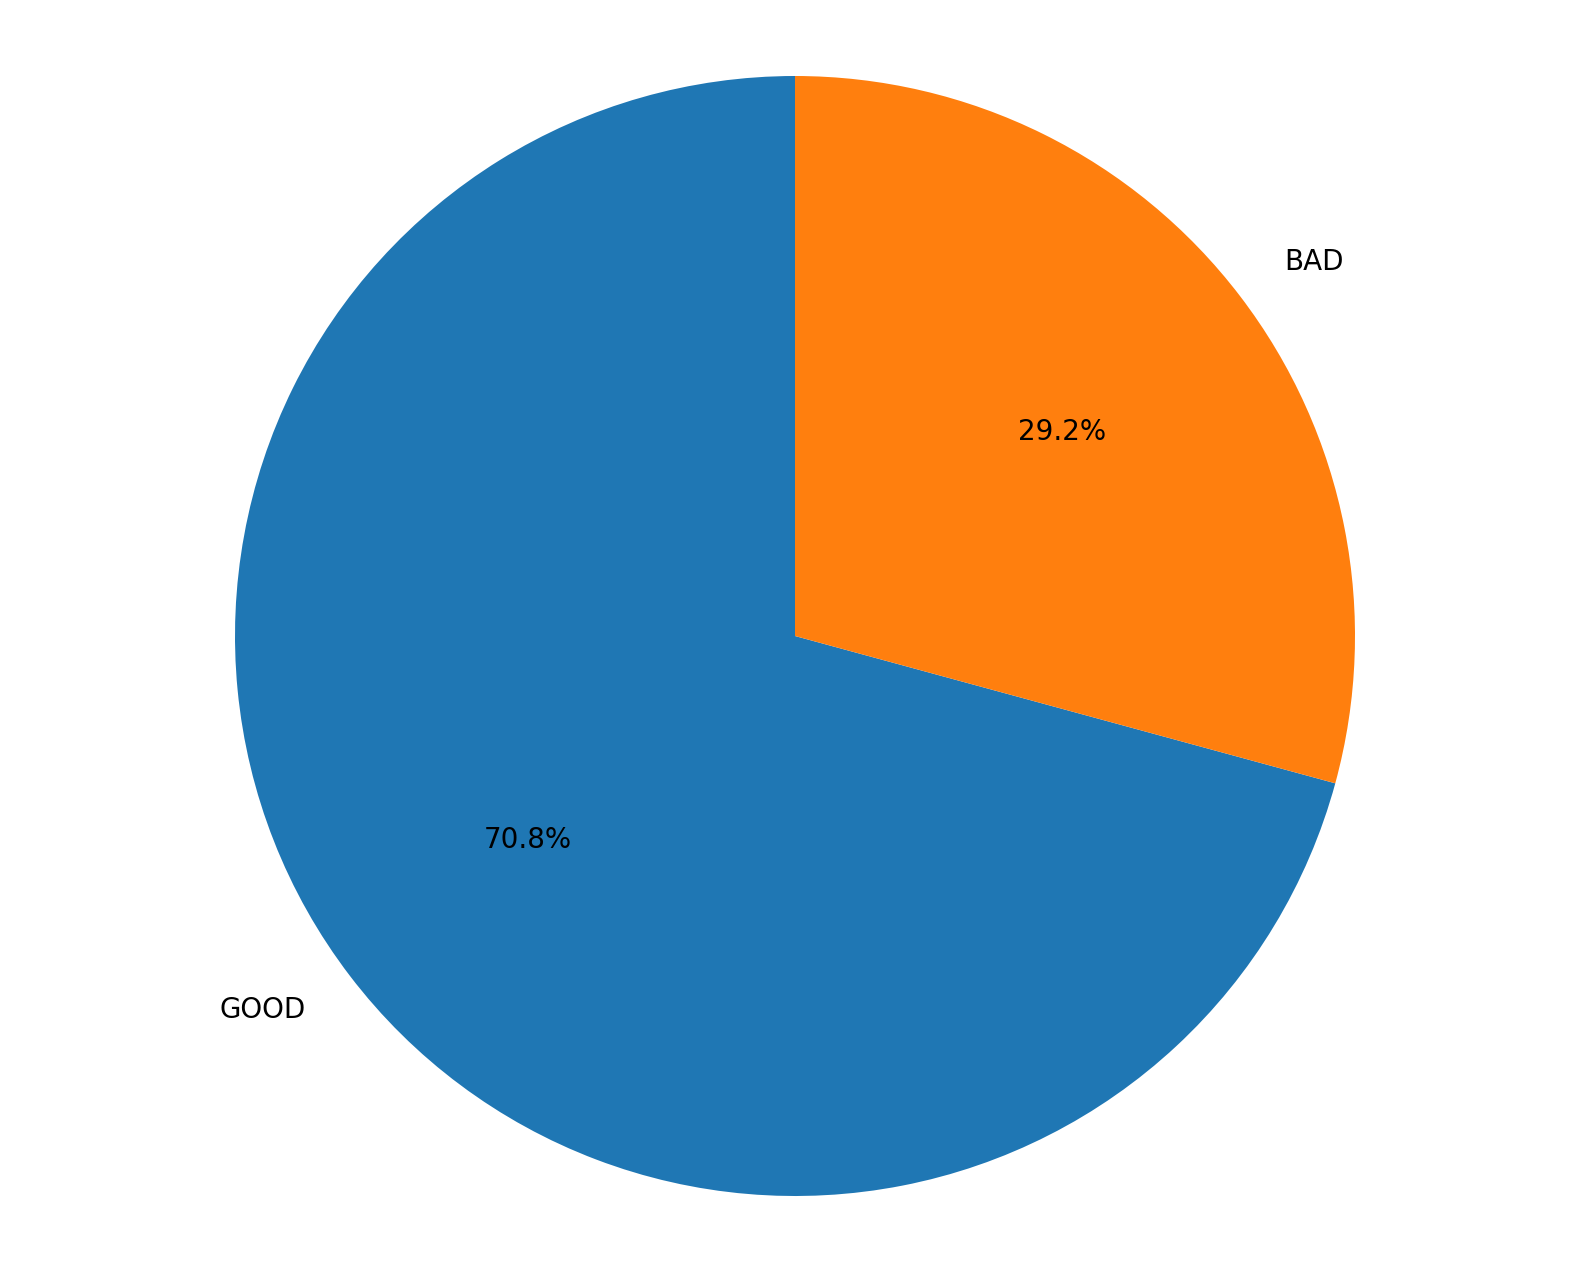

In [50]:
import matplotlib.pyplot as plt

# 데이터 준비
good_count = df['y'].value_counts()[1]
bad_count = df['y'].value_counts()[0]

sizes = [good_count, bad_count]  # 1(맛집)과 0(맛집 아님)의 개수
labels = ['GOOD', 'BAD']

# 원형 차트 그리기
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# 원형 차트의 동그란 모양 유지
ax1.axis('equal')

# 표시
plt.show()